In [1]:
import fns
from fns.functionsTFhardbound import *
%matplotlib inline

today = datetime.date.today()
todayStr = '%04d%02d%02d' % (today.year, today.month, today.day)
# todayStr = '20151005'
DIRECTORY = os.path.expanduser("~/Dropbox/0000_PhD/figures/"+todayStr+"/")
CSV_DIR_TODAY = os.path.expanduser("~/Dropbox/0000_PhD/csv/"+todayStr+"/")
CSV_DIR = os.path.expanduser("~/Dropbox/0000_PhD/csv/")
FIG_DIR = os.path.expanduser("~/Dropbox/0000_PhD/figures/")
if not os.path.exists(DIRECTORY):
    os.makedirs(DIRECTORY)
    
from bokeh.io import output_notebook
output_notebook()
from IPython.display import clear_output, Image, display

********************************************************************************
functionsTFhardbound loaded!
********************************************************************************


Loading BokehJS ...

In [2]:
PAPER = os.path.expanduser('~/Dropbox/ICL-2014/Presentations/2016-10-11-GJ-sync-paper/figures/')

In [3]:
plt.style.use(['seaborn-paper'])
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.5})


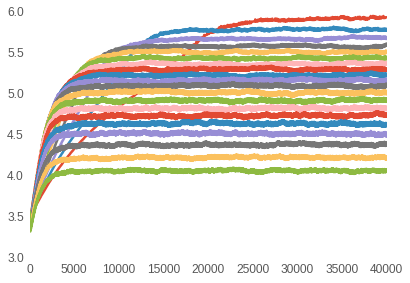

In [6]:
gR=[]
for k in np.arange(0,200,10):
    a = np.load('GetSteadyState4-tauv-15_g-7_N-1000_T-40000_k-%d'%k)
    plt.plot(a['gamma'])
    gR.append(a['gamma'])

In [7]:
a = np.load('GetSteadyState4-tauv-15_g-7_N-1000_T-40000_k-0')

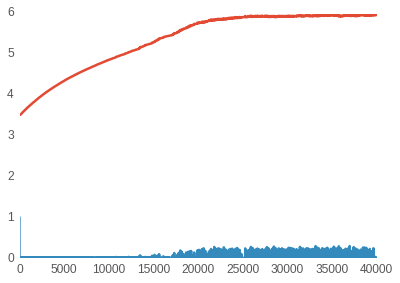

In [9]:
plt.plot(a['gamma'])
plt.plot(a['vvm'])

array([ 1.,  1.])

In [6]:
N, g, tauv, i, nu = 2000, 14,15,0,200
T = 100

gpu = TfSingleNet(N=N,
                  T=T,
                  disp=False,
                  tauv=45,
                  device='/gpu:0',
                  spikeMonitor=False,
                  g0=g,
                  startPlast = 50,
                  nu = nu,
                  NUM_CORES = 1)
# gpu.input = apple
print(gpu.lowspthresh)
gpu.lowspthresh = 1.5
gpu.ratio = 200
gpu.FACT = 200
gpu.runTFSimul()

    

1.3
0.71


In [8]:
tf.__git_version__

"b'v0.11.0rc0-1040-g46110c5-dirty'"

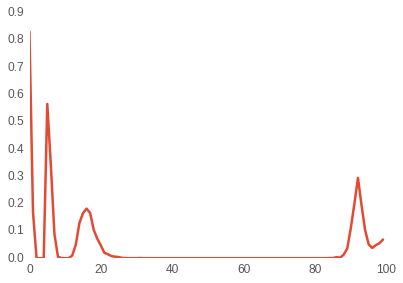

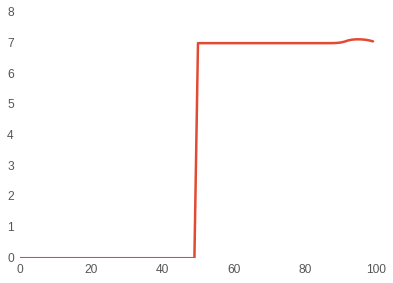

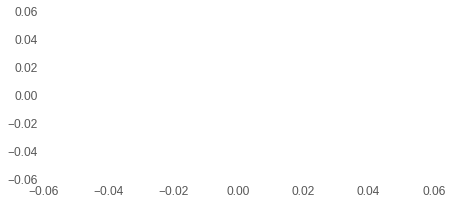

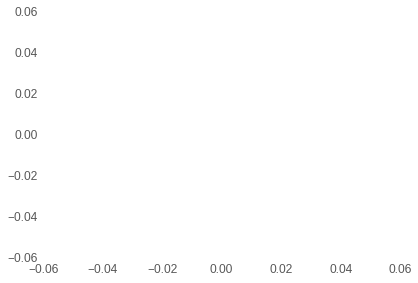

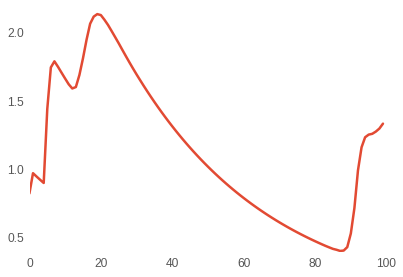

In [7]:
plt.plot(gpu.vvm)
plt.figure()
plt.plot(gpu.gamma)

t0 = 8000
t1 = 9000
plt.figure(figsize=(7,3))
plt.plot(gpu.vvm[t0:t1])
plt.figure()
plt.plot(gpu.gamma[t0:t1])
plt.figure()
plt.plot(np.mean(np.array(gpu.lowsp).reshape(T,N).transpose(), axis=0))

In [28]:
df = pd.DataFrame(columns=('nu', 'g', 'T', 'N', 'f', 'p', 'burst', 'spike', 'ratio'
                          ) )
i=-1
d = 2000
d2 = 7000
start = 5900
s0 = 100
sigma = 8
params=[]
for T in [8000]:
        for N in [1000]:
            for g in np.arange(0, 15, 0.5):
                for nu in np.arange(0, 200, 5):
                        i+=1
                        params.append([T, N, g, nu, i])

def getDF(params):
    T, N, g, nu, i = params
    filename = "../data/PhasePlan4/PhasePlan4_nu-%d_g-%.2f_N-%d_input-%s_T-%d" % (nu, g, N, 'noise', T)
    a = np.load(filename)
    I = a['i']

    # compute frequency and power with fourier transform of the lfp (mean current)
    f = fourier(I[10:])[0]
    p = fourier(I[10:])[1]

    return [i, int(nu), g, int(T), int(N), f, p, 
                 float(a['burst']), float(a['spike']), (a['burst']/a['spike'])]
    
q = Pool(nodes=56)
re = q.amap(getDF, params)
res = re.get()
for r in res:
    df.loc[r[0]]=r[1:]

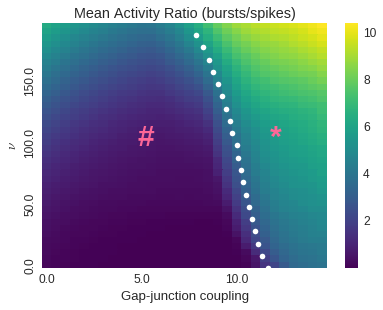

In [48]:
cols = ['f', 'p']
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.5})
# df = df_[(df_['g']<3)&(df_['nu']<20)]
def setLabels(fig):
    color = '#FF6898'
    fig.text(5*2, 20, '#', fontweight='bold', fontsize=30, color=color)
    fig.text(12*2, 20, '*', fontweight='bold', fontsize=30, color=color)
    fig.set_ylabel(r'$\nu$')
    fig.set_xlabel(r'Gap-junction coupling')
    
    

fig = plotHeatmap(df, col='ratio', y='nu', x='g', title='Mean Activity Ratio (bursts/spikes)', cmap='viridis')
setLabels(fig)
gR=[]
for k in np.arange(0,200,10):
    a = np.load('GetSteadyState4-tauv-15_g-7_N-1000_T-40000_k-%d'%k)
    gR.append(a['gamma'])
    plt.plot(a['gamma'][-1]*4,(200-k)/5, 'o', color='w')
plt.savefig(PAPER + 'ratio-steadystate.svg')


## Bursting protocol

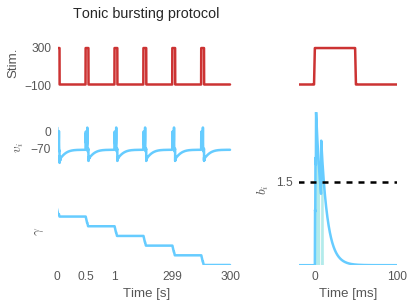

In [15]:
fig = plt.figure(figsize=(6,4.5))

class Izh:
    def __init__(self, T=3000, tauv=15):
        self.bTh = 1.5
        self.u_, self.v_, self.p_, self.lowsp_, self.vv_, self.gamma_ = [], [], [], [], [], []
        self.alphaLTD = 4.7e-6
        self.T = T
        self.tauv = tauv
        # stimulation
        self.I = [300 if i%500<50 else -82 for i in range(T)]
        
    def sim(self):
        dt = 0.25
        v = -70
        u, lowsp, p = 0, 0, 0
        gamma = 10
        for i in range(self.T):
            # voltage
            v = v + dt / self.tauv * ((v+60) * (v+50) - 20 * u + 8 * self.I[i])
            # adaptation
            u = u + dt * 0.044 * (v+55 - u)
            # spike
            vv = v> 25
            # reset
            v = vv * -40 + (1-vv)*v
            u = u + vv * 50
            # burst
            lowsp = lowsp + dt/8.0 * (vv * 8.0/dt - lowsp)
            p = lowsp>self.bTh
            gamma += p*(-self.alphaLTD)
            # save stuffs
            self.lowsp_.append(lowsp)
            self.p_.append(p)
            self.v_.append(v)
            self.u_.append(u)
            self.vv_.append(vv)
            self.gamma_.append(gamma)

izh = Izh(T=3000)
izh.sim()
T = izh.T
t = np.arange(T)
dt = 0.25

## PLOT FIGURE 2
ax1 = plt.subplot2grid((3, 5), (0, 0), colspan=3)
ax = plt.subplot2grid((3, 5), (1, 0), colspan=3)
ax2 = plt.subplot2grid((3, 5), (2, 0), colspan=3)
ax3 = plt.subplot2grid((3, 5), (1, 3), rowspan=2, colspan=2)
ax4 = plt.subplot2grid((3, 5), (0, 3), colspan=2)

# bursting neurons
bursting  = izh.p_

xlim=[0,3100]
##########################################
# V
##########################################
ax.plot(t, izh.v_, label='membrane voltage [mV]', color="#66ccff")

ax.set_xlim(xlim)
ax.set_ylim([-200, 80])
ax.set_yticks([-70,0])
ax.set_title("")
ax.set_xticklabels([])
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.set_ylabel(r'$v_i$')
ax.set_axis_bgcolor((1, 1,1))
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

##########################################
# stim
##########################################
#     ax1.plot(s.t, ((s.stim - min(s.stim))/(max(s.stim) - min(s.stim)))*10, label='stimulation [pA]')
ax1.plot(t, izh.I, label='stimulation [pA]', color="#cc3333")

ax1.set_xlim(xlim)
ax1.set_ylim([-210,510])
ax1.set_yticks([-100,300])
ax1.set_axis_bgcolor((1, 1,1))
ax1.set_xticklabels([])
ax1.set_ylabel('Stim.')

# gamma
ax2.plot(t, np.array(izh.gamma_),"#66ccff")

ax2.set_xlim(xlim)

ax2.spines['right'].set_color('none')
ax2.spines['top'].set_color('none')
ax2.xaxis.set_ticks_position('bottom')
ax2.yaxis.set_ticks_position('left')
ax2.set_xlabel('Time [s]')
ax2.set_ylabel(r'$\gamma$')
ax2.set_axis_bgcolor((1, 1,1))
ax2.set_xticks([0,500,1000,2000,3000])
ax2.set_xticklabels([0,0.5,1,299,300])
ax2.set_yticks([10])
ax2.set_yticklabels('')


ax4.plot(t, izh.I, label='stimulation [pA]', color="#cc3333")
ax4.set_xlim([480,600])
ax4.set_ylim([-210,510])
ax4.set_yticks([])
ax4.set_xticks([500,550,600])
ax4.set_xticklabels([])
ax4.set_axis_bgcolor((1, 1,1))
ax4.set_xticklabels([])    

ax3.plot(t*dt, np.array(izh.lowsp_),"#66ccff", t*dt, np.ones(T)*izh.bTh, 'k--')
ax3.set_yticks([izh.bTh])
ax3.fill(t*dt, bursting*np.array(izh.lowsp_), facecolor='c', alpha=0.3,)
ax3.set_xlim([480,600])

ax3.spines['right'].set_color('none')
ax3.spines['top'].set_color('none')
ax3.xaxis.set_ticks_position('bottom')
ax3.yaxis.set_ticks_position('left')
ax3.set_xlabel('Time [ms]')
ax3.set_ylabel(r'$b_i$')
ax3.set_axis_bgcolor((1, 1,1))
ax3.set_xticks([500,550,600])
ax3.set_xticklabels([0,'',100])

ax1.set_title('Tonic bursting protocol', y=1.08)
plt.tight_layout()

# show()
plt.savefig(PAPER + 'fig2-bursting_protocol.svg', bbox_inches='tight', pad_inches=0)

In [25]:
gpu = TfSingleNet(N=2,
                  T=1000,
                  disp=False,
                  tauv=15,
                  device='/cpu:0',
                  spikeMonitor=True,
                  g0=8,
                  startPlast = 0,
                  nu = 0,
                  NUM_CORES = 1)
gpu.ratio = 3
gpu.input = np.concatenate([np.ones(500)*0,np.ones(500)*200])
gpu.runTFSimul()

1.81


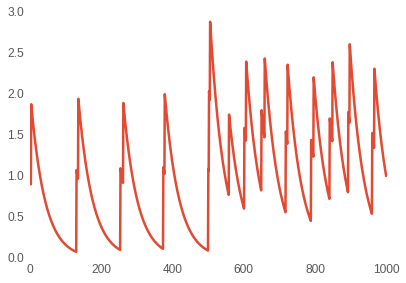

In [26]:
dep = np.array(gpu.lowsp)[:,0]
plt.plot(dep)

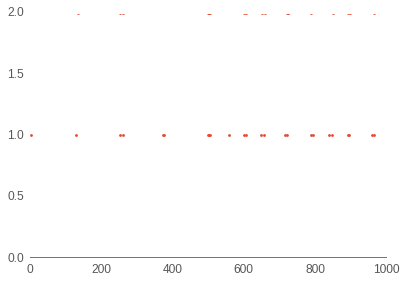

In [27]:
# # plt.imshow(gpu.raster.transpose())
# plt.figure()
spikes = gpu.raster.transpose()
# # plt.plot(spikes)

y = np.concatenate([spikes[i,:]*(i+1) for i in range(spikes.shape[0])])
x = list(np.arange(spikes.shape[1]))*spikes.shape[0]
plt.plot(x,y,'.')

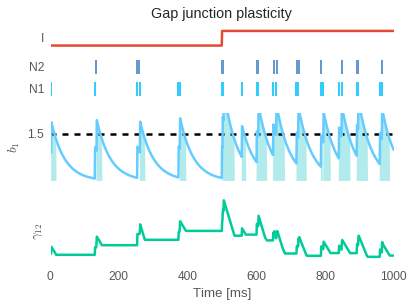

In [28]:
xlim = [1950,2050]
gammaColor = '#00cc99'
# P = gr.fourier(ssp1)
titlestr= 'Gap junction plasticity'

fig = plt.figure(figsize=(6,4.5))

N1 =[]
N2 = []
for i in range(len(x)):
    if y[i] == 2:
        N2.append([x[i],y[i]])
    elif y[i]==1:
        N1.append([x[i],y[i]])
N1 = np.array(N1)
N2 = np.array(N2)




### SPIKES
ax=fig.add_subplot(311)
ax.set_title(titlestr, y=1.08)
ax.plot(N1[:,0], N1[:,1], '|', color='#33ccff', markersize=14, markeredgewidth=2)
ax.plot(N2[:,0], N2[:,1]+0.5, '|', color='#6699cc', markersize=14,markeredgewidth=2)
# ax.set_xlim(xlim)
ax.set_ylim([-10,12])
ax.set_yticklabels([])

# stimulation
st=[]
for i in range((1000)):
    st.append(5 if i>500 else 4)
ax.plot(st)
# ax.set_xlim(xlim)
ax.set_xticks([])
ax.set_yticks([1,2.5,4.5])
ax.set_yticklabels(['N1', 'N2','I'])
ax.set_ylim([0.5,5.2])
ax.set_axis_bgcolor((1,1,1))

# # ax.set_ylim([-1,55])


### low sp threshold
ax = fig.add_subplot(312)
dep = np.array(gpu.lowsp)[:,0]
ax.plot(np.ones(len(dep))*1.5, 'k--')
ax.fill(np.arange(len(dep)), dep*(dep>1.3), facecolor='c', alpha=0.3,)
ax.plot(dep,"#66ccff")
ax.set_ylabel(r'$b_1$')
ax.set_xticks([])
ax.set_yticks([1.5])
ax.set_ylim([0,2.2])


### GAMMA
ax= fig.add_subplot(313)
# ax.set_xticklabels([])
# ax.set_xlim([1.95,2.05])
# ax.set_ylim([2.487,2.4876])
# ax.set_yticks([2.487,2.4875])
# ax.set_yticklabels(['2.487','2.4875'], fontsize=12)
ax.plot(gpu.gamma, color=gammaColor)
# ax.set_ylim([2.504,2.5052])
ax.set_ylabel(r'$\gamma_{12}$')
ax.set_xlabel('Time [ms]')
ax.set_yticks([])
# ax.set_xticks([1.950,2.050])
# ax.set_xticklabels([0,100])

plt.tight_layout()
plt.savefig(PAPER+'fig2-plasticity.svg')

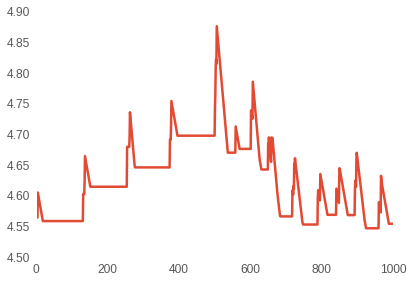

In [29]:
plt.plot(gpu.gamma)

## HAAS protocol

In [16]:
izh = Izh(T=3000)
izh.sim()
T = izh.T
t = np.arange(T)
dt = 0.25

In [27]:
def computeLTD(LTD, V0, burstime, dt):
    V = V0
    res_v = []
    for iteration in range(100):
        for i in range(len(izh.p_)):
            if izh.p_[i]:
                V -= LTD*V0*dt
            res_v.append(V)
    return V, res_v    

In [28]:
def dichotomy(eps, goal, nbiter=20, dt=0.25):
    nbiter = 0
    err = 1
    res = 0.0010
    mmin = 0
    mmax = 0.0010
    LTD = 0.005
    g0 = 10
    i=0
    c = 0.005
    while(err > eps):
        i += 1
        c = (mmax-mmin)/2.000000000 + mmin
        res, _ = computeLTD(c, g0, izh.p_, dt)
        if res < goal:
            mmax = c
            sign = 1
        else:
            mmin = c
            sign = -1
        err = abs(goal- res)
        
    print(c) 
    return c

In [29]:
# dt = 0.25
# bTh = 1.3 

# dt = 0.25
# bTh = 1.3 


# n = IzhNeuron("", a=0.02, b=0.25, c=-50, d=2, v0=-70)
# s = IzhSim(n, T=3000, dt=dt)
# for i, t in enumerate(s.t):
#     s.stim[i] = 300 if (t)%500<50 else -82
# sims.append(s)


# for i,s in enumerate(sims):
#     res = s.integrate()
    
# burstime = np.array(res[2]>bTh)

In [30]:
LTD = dichotomy(1e-5, 10*0.87, dt)
_, res_v = computeLTD( LTD, 5.0, izh.p_, dt)

2.4528264999389653e-05


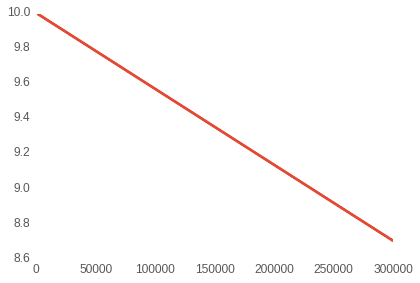

In [32]:
_, res_v = computeLTD( LTD, 10.0, izh.p_*100, dt)
plt.plot(res_v[:4*5*60*1000])

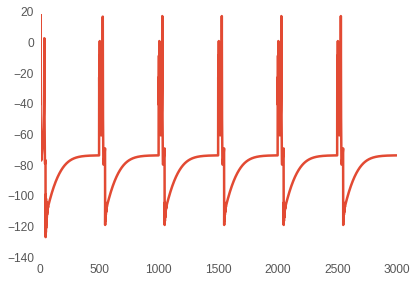

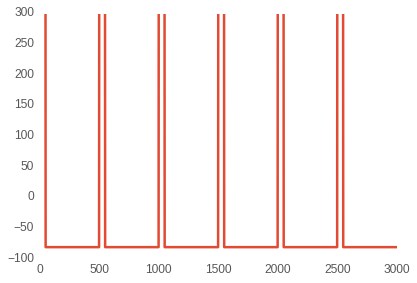

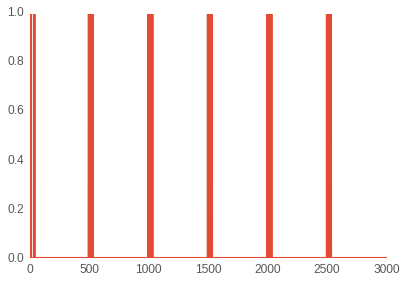

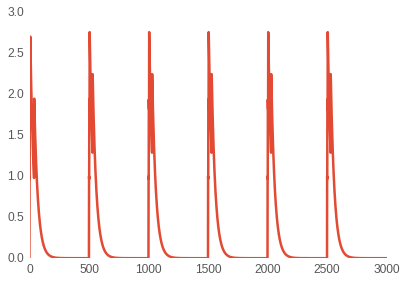

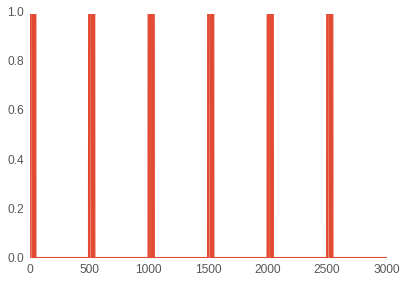

In [33]:
plt.plot(izh.v_)

plt.figure() 
plt.plot(izh.I)

plt.figure()
plt.plot(izh.vv_)

plt.figure()
plt.plot(izh.lowsp_)

plt.figure()
plt.plot(izh.p_)